# Data Cleaning
Brandon Shellenberger

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

## Making Global Variables

In [2]:
PROJECT_ROOT = pathlib.Path().parent.parent
DATA_FOLDER = PROJECT_ROOT.joinpath('data')
# Used Excel to clear out data to reduce dropping of NaNs
# Now each city has 108 entries, enough for regression analysis
TIME_SERIES_DATA = DATA_FOLDER.joinpath('zillow_time_series_cleaned.csv')
HOUSE_PRICING_DATA = DATA_FOLDER.joinpath('kaggle_house_pricing.csv')

## Cleaning Zillow Data
Make sure to record everything for the write up.

### Handling with NaN, Duplicates, unrelated columns, renaming columns

In [ ]:
zillow_ts = pd.read_csv(TIME_SERIES_DATA)

# Dropping columns, NaNs, and duplicates
zillow_dropping = zillow_ts.drop(columns=['RegionID', 'StateName', 'RegionType', 'SizeRank']).dropna().drop_duplicates()

# Setting the first column as the index, transpose (.T), rename index to date, reset index, rename index as None
zillow_transposed = zillow_dropping.set_index(zillow_dropping.columns[0]).T.rename_axis('date').reset_index().rename_axis(None, axis=1)

# Changing date column data types to datetime
zillow_transposed['date'] = pd.to_datetime(zillow_transposed['date'])
print(zillow_transposed.dtypes)
zillow_clean_df = zillow_transposed

print(zillow_clean_df.head(5))

date               datetime64[ns]
United States             float64
New York, NY              float64
Los Angeles, CA           float64
Chicago, IL               float64
                        ...      
Zapata, TX                float64
Ketchikan, AK             float64
Craig, CO                 float64
Vernon, TX                float64
Lamesa, TX                float64
Length: 884, dtype: object
        date  United States  New York, NY  Los Angeles, CA  Chicago, IL  \
0 2016-02-29    195038.6732   417498.4951      520578.9987  206810.5608   
1 2016-03-31    195860.9671   418183.7542      533538.0808  207549.8202   
2 2016-04-30    196607.1322   419081.9497      543145.7952  208213.1399   
3 2016-05-31    197362.8313   420236.2414      548929.0334  208767.1935   
4 2016-06-30    198284.9011   421749.8304      553538.7738  209480.1560   

    Dallas, TX  Houston, TX  Washington, DC  Philadelphia, PA    Miami, FL  \
0  195875.9219  193991.5365     395847.6906       213524.1890  270961.

### Looking for outliers
With time-series data, there should not be any outliers.

Text(0, 0.5, 'Median Price of Single Family Houses')

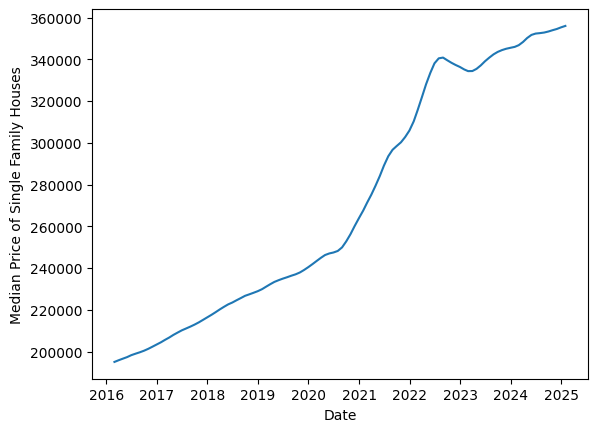

In [4]:
sns.lineplot(data=zillow_clean_df, x='date', y='United States')
plt.xlabel('Date')
plt.ylabel('Median Price of Single Family Houses')